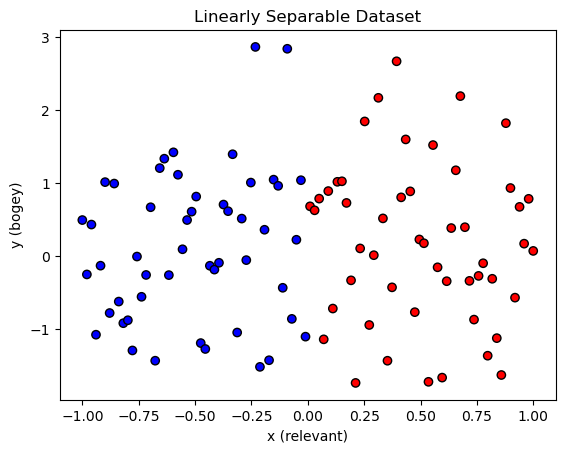

In [1]:
import torch
import matplotlib.pyplot as plt

# Generate a simple 2D linearly separable dataset
num_points = 100

# x values uniformly sampled from -1 to 1
x = torch.linspace(-1, 1, num_points)

# Random y values (bogey dimension)
y = torch.randn(num_points)  # This dimension is irrelevant

# Labels: 1 if x > 0, else 0
Y = (x > 0).int()

# Stack into a 2D dataset
X = torch.stack([x, y], dim=1)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="bwr", edgecolors="k")
plt.xlabel("x (relevant)")
plt.ylabel("y (bogey)")
plt.title("Linearly Separable Dataset")
plt.show()

# Create a dataloader for the dataset
dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Split the dataset into a training and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)


In [2]:
import torch
from model.fully_connected_network import FullyConnectedNetwork
from core.energy import HopfieldEnergy
from core.updater import FixedPointUpdater
from training.runner import Runner
from training.cost import SquaredError
from training.equilibrium_propagation import EquilibriumProp
from util.config import Config

config = Config()
config.training["num_epochs"] = 5
network = FullyConnectedNetwork(config)
energy_fn = HopfieldEnergy(config)
cost_fn = SquaredError(config)
updater = FixedPointUpdater(network, energy_fn, cost_fn, config)

W, B = network.weights, torch.tensor(0.0) #network.bias # Need to verify if pointer or new creation. It should be pointer already but sanity check. 
optimizer = torch.optim.SGD([W, B], lr=0.5)
differentiator = EquilibriumProp(network, energy_fn, cost_fn, updater, config, optimizer)



config.path = "./results"

runner = Runner(config, network, train_loader, differentiator, updater, optimizer, inference_dataloader=test_loader)
runner.run_training()

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


Epochs:  20%|██        | 1/5 [00:00<00:00,  4.57it/s]

Epoch: 0, Energy: 0.0000, Accuracy: 0.4000
Epoch: 1


Epochs:  40%|████      | 2/5 [00:00<00:00,  5.03it/s]

Epoch: 1, Energy: 0.0000, Accuracy: 0.4000
Epoch: 2


Epochs:  60%|██████    | 3/5 [00:00<00:00,  4.14it/s]

Epoch: 2, Energy: 0.0000, Accuracy: 0.4000
Epoch: 3


Epochs:  80%|████████  | 4/5 [00:00<00:00,  4.72it/s]

Epoch: 3, Energy: 0.0000, Accuracy: 0.4000
Epoch: 4


Epochs: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]

Epoch: 4, Energy: 0.0000, Accuracy: 0.4000


0.4

In [ ]:
from tqdm import tqdm
from collections import deque

correctness_log = deque(maxlen=5)

iter = 0
for x, target in tqdm(runner._dataloader, desc="Training Batches"):
    if iter > 200:
        break
    iter += 1

    runner._optimizer.zero_grad()
    S = runner._network.set_input(x)
    W, B = runner._network.weights, runner._network.biases

    W.data = torch.tensor([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0],[1.0, 0.0, 1.0]])
                            

    S = runner._updater.compute_equilibrium(S, W, B, target)
    weight_grads, bias_grads = runner._differentiator.compute_gradient(S, W, B, target)
    W.grad, B.grad = weight_grads, bias_grads
    runner._optimizer.step()

    W.data = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0],[1.0, 0.0, 1.0]])

    B.data = torch.tensor([0.0, 0.0, 1.0])

    S_pred = runner._updater.compute_equilibrium_pred(S, W, B)
    pred_value = round(S_pred.flatten().detach().numpy()[-1], 3)
    target_value = target.detach().numpy()[0]
    correct = int(pred_value == target_value)

    correctness_log.append(correct)
    rolling_accuracy = sum(correctness_log) / len(correctness_log)

    print(f"\nSample {iter}, Target: {target_value}, Prediction: {pred_value}, Correct: {correct}")
    print("X:", [round(a, 3) for a in x.flatten().detach().numpy()])
    print("W:", [[round(a, 3) for a in row] for row in W.detach().numpy()])
    print("B:", [round(a, 3) for a in B.detach().numpy()])
    print("S:", [round(a, 3) for a in S.flatten().detach().numpy()])

    print(f"Rolling Accuracy (Last {len(correctness_log)} samples): {round(rolling_accuracy * 100, 2)}%")


Training Batches:  79%|███████▉  | 63/80 [00:00<00:00, 323.08it/s]


Sample 1, Target: 1, Prediction: 0.0, Correct: 0
X: [0.98, 0.789]
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]
B: [0.0, 0.0, 1.0]
S: [0.98, 0.789, 0.0]
Rolling Accuracy (Last 1 samples): 0.0%

Sample 2, Target: 0, Prediction: 0.0, Correct: 1
X: [-0.879, -0.775]
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]
B: [0.0, 0.0, 1.0]
S: [-0.879, -0.775, 0.0]
Rolling Accuracy (Last 2 samples): 50.0%

Sample 3, Target: 1, Prediction: 0.0, Correct: 0
X: [0.838, -1.119]
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]
B: [0.0, 0.0, 1.0]
S: [0.838, -1.119, 0.0]
Rolling Accuracy (Last 3 samples): 33.33%

Sample 4, Target: 0, Prediction: 0.0, Correct: 1
X: [-0.212, -1.512]
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]
B: [0.0, 0.0, 1.0]
S: [-0.212, -1.512, 0.0]
Rolling Accuracy (Last 4 samples): 50.0%

Sample 5, Target: 0, Prediction: 0.0, Correct: 1
X: [-1.0, 0.498]
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]
B: [0.0, 0.0, 1.0]
S: [-1.0, 0.498, 0.0]
Rolli

Training Batches: 100%|██████████| 80/80 [00:00<00:00, 318.67it/s]


Sample 64, Target: 0, Prediction: 0.0, Correct: 1
X: [-0.636, 1.339]
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]
B: [0.0, 0.0, 1.0]
S: [-0.636, 1.339, 0.0]
Rolling Accuracy (Last 5 samples): 80.0%

Sample 65, Target: 1, Prediction: 0.0, Correct: 0
X: [0.212, -1.732]
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]
B: [0.0, 0.0, 1.0]
S: [0.212, -1.732, 0.0]
Rolling Accuracy (Last 5 samples): 60.0%

Sample 66, Target: 0, Prediction: 0.0, Correct: 1
X: [-0.293, 0.518]
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]
B: [0.0, 0.0, 1.0]
S: [-0.293, 0.518, 0.0]
Rolling Accuracy (Last 5 samples): 80.0%

Sample 67, Target: 1, Prediction: 0.0, Correct: 0
X: [0.273, -0.939]
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]
B: [0.0, 0.0, 1.0]
S: [0.273, -0.939, 0.0]
Rolling Accuracy (Last 5 samples): 60.0%

Sample 68, Target: 1, Prediction: 0.0, Correct: 0
X: [0.01, 0.686]
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]]
B: [0.0, 0.0, 1.0]
S: [0.01, 0.686, 0.0]


In [40]:
from tqdm import tqdm

iter = 0
for x, target in tqdm(runner._dataloader, desc="Training Batches"):
    if iter > 5:
        break
    iter += 1

    # Zero gradients for the current batch
    runner._optimizer.zero_grad()

    # Set the input and retrieve current parameters
    S = runner._network.set_input(x)

    # Retrieve weights and biases
    W, B = runner._network.weights, runner._network.biases

    # Let the network settle to equilibrium
    S = runner._updater.compute_equilibrium(S, W, B, target)

    # Compute parameter gradients
    weight_grads, bias_grads = runner._differentiator.compute_gradient(S, W, B, target)

    # Assign gradients to parameters
    W.grad, B.grad = weight_grads, bias_grads

    # Update parameters
    runner._optimizer.step()

    # Print relevant values
    print("\nNew Sample, target =", target.detach().numpy()[0])
    print("X:", [round(a, 3) for a in x.flatten().detach().numpy()])
    print("S:", [round(a, 3) for a in S.flatten().detach().numpy()])
    
    # Compute predicted equilibrium state
    S_pred = runner._updater.compute_equilibrium_pred(S, W, B)
    
    print("Target:", target.numpy(), "Prediction:", round(S_pred.flatten().detach().numpy()[-1],3))
    
    # Print weights and biases
    print("W:", [[round(a, 3) for a in row] for row in W.detach().numpy()])
    print("B:", [round(a, 3) for a in B.detach().numpy()])


Training Batches:   8%|▊         | 6/80 [00:00<00:00, 330.71it/s]


New Sample, target = 1
X: [0.313, 0.845]
S: [0.313, 0.845, 1.0]
Target: [1] Prediction: 1.0
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [-0.867, -1.511, 0.607]]
B: [0.0, 0.0, 0.0]

New Sample, target = 0
X: [-0.919, -1.498]
S: [-0.919, -1.498, 0.0]
Target: [0] Prediction: 1.0
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.511, 0.736, -1.689]]
B: [0.0, 0.0, 0.0]

New Sample, target = 1
X: [0.899, -0.502]
S: [0.899, -0.502, 1.0]
Target: [1] Prediction: 1.0
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [-1.221, 0.938, 0.777]]
B: [0.0, 0.0, 0.0]

New Sample, target = 0
X: [-0.495, 0.436]
S: [-0.495, 0.436, 0.0]
Target: [0] Prediction: 0.0
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [-0.478, 0.284, 0.017]]
B: [0.0, 0.0, 0.0]

New Sample, target = 0
X: [-0.03, 1.034]
S: [-0.03, 1.034, 0.0]
Target: [0] Prediction: 1.0
W: [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [-0.433, -1.267, -0.214]]
B: [0.0, 0.0, 0.0]

New Sample, target = 0
X: [-0.01, 0.792]
S: [-0.01, 0.792, 1.0]
Target: [0] Prediction: 1.0
W: [[1.0, 0.0, 0.0], [0.0,

In [15]:
network._layer_shapes

[2, 1]

In [21]:
S, W, B = runner.training_epoch()

# Update network state
network._weights = W
network._state = S
network._biases = B
W1 = W[:]

print(S)

Training Batches: 100%|██████████| 80/80 [00:00<00:00, 526.59it/s]

tensor([[0.6566, 0.6817, 0.0000]], grad_fn=<CopySlices>)


In [17]:
S

tensor([[ 0.3737, -1.4788,  0.0000]], grad_fn=<CopySlices>)

In [18]:
W

Parameter containing:
tensor([[ 1.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000],
        [-0.7722, -0.2279, -1.9655]], requires_grad=True)

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

In [ ]:
runner.run_training()

Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0


Epochs:   0%|          | 0/25 [00:07<?, ?it/s]


torch.Size([1, 69])
torch.Size([69, 69])
torch.Size([69])
12


ValueError: Invalid node index

In [ ]:
import os,sys 
notebook_dir = os.getcwd()
sys.path.append(os.path.dirname(notebook_dir))

import torch
from model._network import Network
from model.fully_connected_network import FullyConnectedNetwork



network = FullyConnectedNetwork(config, [3,4,4,2])
network.set_input(torch.Tensor([1,2,3]))
network.biases[3:11] = 0
network._weights[3,7]=2

def update(network: Network):
    network._state = torch.matmul(network.weights, network.state) + network.biases
    print(network.state)


update(network)
update(network)
update(network)
update(network)
update(network)

IndexError: tuple index out of range